# Demand Analysis

In [16]:
# Import libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load your sales data
sales_df = pd.read_csv('clothing_reviews.csv')  # Example: columns ['Order_ID', 'Product_ID', 'Quantity', 'Date']

sales_df.head()


,Customer ID,Customer Name,Customer Age,Gender,Purchase Date,product_id,Product Category,product_name,Quantity,Payment Method,Review Text,Rating
0,46251.0,Christine Hernandez,37.0,Male,12-11-2020 13:13,778036.0,Clothing,Slim Fit Tank Top with Denim Fabric,1.0,PayPal,Absolutely wonderful - silky and sexy and comf...,4.0
1,13593.0,James Grant,49.0,Female,05-05-2020 20:14,905147.0,Clothing,Fitted Jacket with Breathable Fabric,2.0,PayPal,Love this dress! it's sooo pretty. i happene...,5.0
2,13593.0,James Grant,49.0,Female,05-05-2020 20:14,938121.0,Clothing,Fitted Jacket with Breathable Fabric,2.0,PayPal,Love this dress! it's sooo pretty. i happene...,5.0
3,28805.0,Jose Collier,19.0,Male,31-03-2021 09:50,763149.0,Clothing,Textured T-Shirt with Cotton Fabric,1.0,PayPal,I had such high hopes for this dress and reall...,3.0
4,28805.0,Jose Collier,19.0,Male,02-07-2020 02:54,708904.0,Clothing,Acid Wash Cargo Pants with Cotton Fabric,1.0,Credit Card,"I love, love, love this jumpsuit. it's fun, fl...",5.0


In [9]:
products_df = pd.read_csv('clothing_description.csv')
products_df.head()

,product_id,product_name,product_brand,product_category,sub_category,product_description,size,color,price,material,gender
0,636938,Vintage Cargo Pants with Eco-Friendly Fabric,Versace,Clothing,Pants,Classic and modern design with premium materials.,"XS, S, M, L",Green,7223.49,Wool,Unisex
1,923314,Printed Tank Top with Lightweight Fabric,Nike,Clothing,Tank Tops,Designed for both casual and formal occasions.,"XS, S, M, L",Blue,3808.87,Cotton,Unisex
2,520072,Slim Fit T-Shirt with Eco-Friendly Fabric,Levi's,Clothing,T-Shirts,Trendy and versatile clothing piece.,"S, M, L, XL",Pink,13756.42,Denim,Women
3,671796,Slim Fit T-Shirt with Cotton Fabric,Nike,Clothing,T-Shirts,Perfect fit with high-quality fabric.,"M, L, XL",Blue,11130.30,Denim,Men
4,821136,Ripped Tank Top with Fleece Fabric,Zara,Clothing,Tank Tops,Perfect fit with high-quality fabric.,"S, M, L",Pink,5640.68,Silk,Women


# 1. Best-Selling / Trending Products (Customer page)

In [10]:
import pandas as pd

# Load the datasets
products_df = pd.read_csv('clothing_description.csv')
reviews_df = pd.read_csv('clothing_reviews.csv')

# Step 1: Find Best-Selling Products
best_sellers = reviews_df.groupby('product_id')['Quantity'].sum().sort_values(ascending=False)

# Step 2: Top 10 Trending Product IDs
top_trending_ids = best_sellers.head(10).index.tolist()

# Step 3: Count number of non-empty reviews per product
review_counts = reviews_df[reviews_df['Review Text'].notnull()].groupby('product_id')['Review Text'].count().reset_index()
review_counts.rename(columns={'Review Text': 'num_reviews'}, inplace=True)

# Step 4: Get product details for trending products
trending_products = products_df[products_df['product_id'].isin(top_trending_ids)]

# Step 5: Merge with review counts
trending_products = trending_products.merge(review_counts, on='product_id', how='left')
trending_products['num_reviews'].fillna(0, inplace=True)  # If no reviews, set to 0
trending_products['num_reviews'] = trending_products['num_reviews'].astype(int)

# Optional: Order by sales volume (same as best_sellers)
trending_products['total_quantity'] = trending_products['product_id'].map(best_sellers)
trending_products = trending_products.sort_values(by='total_quantity', ascending=False)

# Step 6: Show Trending Products
print("🔥 Trending Products (Top 10 by Sales) + Number of Reviews:")
print(trending_products[['product_id', 'product_name', 'product_category', 'total_quantity', 'num_reviews']].to_string(index=False))


🔥 Trending Products (Top 10 by Sales) + Number of Reviews:
 product_id                               product_name product_category  total_quantity  num_reviews
     601080 Distressed T-Shirt with Lightweight Fabric         Clothing           677.0          206
     481753 Distressed T-Shirt with Lightweight Fabric         Clothing           677.0          206
     557993 Distressed T-Shirt with Lightweight Fabric         Clothing           677.0          206
     600744           Printed Dress with Fleece Fabric         Clothing           582.0          177
     643895           Printed Dress with Fleece Fabric         Clothing           582.0          177
     572022   Acid Wash Jeans with Eco-Friendly Fabric         Clothing           550.0          178
     379264   Acid Wash Jeans with Eco-Friendly Fabric         Clothing           550.0          178
     912661         Oversized Shirt with Cotton Fabric         Clothing           547.0          175
     604117         Oversized Sh

# 2. Admin Page – Demand Forecasting (Next 6 months)

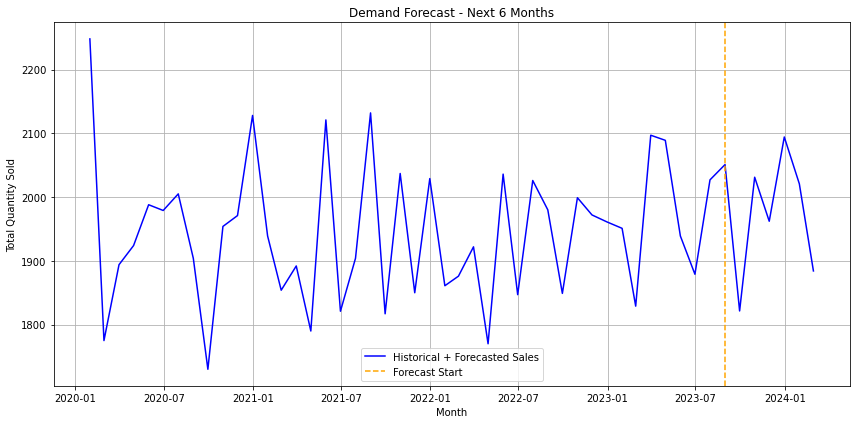

📈 Forecasted Sales for Next 6 Months:
2023-09-30    1821.464700
2023-10-31    2031.139059
2023-11-30    1962.130857
2023-12-31    2094.231818
2024-01-31    2020.776183
2024-02-29    1884.193768
Freq: ME, dtype: float64


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

# Remove rows with missing key values
sales_df = sales_df.dropna(subset=['product_id', 'Quantity', 'Purchase Date'])

# Correct datetime format
sales_df['Purchase Date'] = pd.to_datetime(sales_df['Purchase Date'], format='%d-%m-%Y %H:%M')

# Set datetime as index
sales_df.set_index('Purchase Date', inplace=True)

# Aggregate monthly sales
monthly_total_sales = sales_df.resample('M')['Quantity'].sum()

# Drop the last month if it's not a full month (based on last date)
last_date = sales_df.index.max()
if last_date.day < 28:  # Likely not a full month
    monthly_total_sales = monthly_total_sales[:-1]

# Interpolate any 0s that may have been caused by missing data
monthly_total_sales = monthly_total_sales.replace(0, pd.NA)
monthly_total_sales = monthly_total_sales.interpolate()

# Fit Exponential Smoothing model (additive trend & seasonality)
model = ExponentialSmoothing(monthly_total_sales, trend='add', seasonal='add', seasonal_periods=12).fit()

# Forecast next 6 months
forecast = model.forecast(6)

# --- Key Change: Merge historical and forecast for smoother plot ---
full_series = pd.concat([monthly_total_sales, forecast])

# Plot
plt.figure(figsize=(12,6))
plt.plot(full_series, label='Historical + Forecasted Sales', color='blue')  # Single continuous line
plt.axvline(x=monthly_total_sales.index[-1], color='orange', linestyle='--', label='Forecast Start')  # Mark forecast start
plt.title('Demand Forecast - Next 6 Months')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecasted values
print("📈 Forecasted Sales for Next 6 Months:")
print(forecast)


# Predict high-demand products and alert admin to stock them.

In [11]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load files
desc_df = pd.read_csv('clothing_description.csv')
reviews_df = pd.read_csv('clothing_reviews.csv')

# Convert 'Purchase Date' to datetime
reviews_df['Purchase Date'] = pd.to_datetime(reviews_df['Purchase Date'], dayfirst=True)

# Remove missing or invalid product IDs/quantities
reviews_df.dropna(subset=['product_id', 'Quantity', 'Purchase Date'], inplace=True)


In [12]:
# Set date as index for resampling
reviews_df.set_index('Purchase Date', inplace=True)

# Group by product and month
monthly_sales = reviews_df.groupby(['product_id', pd.Grouper(freq='M')])['Quantity'].sum().reset_index()


In [13]:
alerts = []

for product_id in monthly_sales['product_id'].unique():
    product_data = monthly_sales[monthly_sales['product_id'] == product_id].copy()
    product_data.set_index('Purchase Date', inplace=True)
    ts = product_data['Quantity']

    if len(ts) < 6:
        continue

    try:
        sp = min(12, len(ts))  # Use shorter seasonal period if needed
        model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=sp).fit()
        forecast = model.forecast(1)
        predicted_demand = forecast.iloc[0]

        print(f"Product {product_id} forecasted demand: {predicted_demand:.2f}")  # Debug

        if predicted_demand >= 10:  # Lower threshold for testing
            alerts.append((product_id, round(predicted_demand, 2)))

    except Exception as e:
        print(f"Skipped {product_id} due to error: {e}")


Product 100978.0 forecasted demand: 10.36
Product 106958.0 forecasted demand: 5.30
Product 108133.0 forecasted demand: 7.30
Product 113440.0 forecasted demand: 8.17
Product 114116.0 forecasted demand: 10.33
Product 115619.0 forecasted demand: 3.56
Product 117736.0 forecasted demand: 9.67
Product 117944.0 forecasted demand: 3.40
Product 118011.0 forecasted demand: 1.60
Product 123902.0 forecasted demand: 4.09
Product 124917.0 forecasted demand: 4.19
Product 128364.0 forecasted demand: 6.77
Product 132249.0 forecasted demand: 3.87
Product 133901.0 forecasted demand: 8.71
Product 142005.0 forecasted demand: 6.83
Product 142272.0 forecasted demand: 4.19
Product 148197.0 forecasted demand: 3.58
Product 152221.0 forecasted demand: 4.06
Product 157996.0 forecasted demand: 4.53
Product 159255.0 forecasted demand: 11.40
Product 166789.0 forecasted demand: 6.42
Product 168627.0 forecasted demand: 9.39
Product 169909.0 forecasted demand: 13.58
Product 174697.0 forecasted demand: 5.28
Product 1757

Product 723626.0 forecasted demand: 1.81
Product 724429.0 forecasted demand: 5.36
Product 730821.0 forecasted demand: 5.55
Product 732487.0 forecasted demand: 0.83
Product 732923.0 forecasted demand: 3.93
Product 739379.0 forecasted demand: 9.25
Product 739457.0 forecasted demand: 2.29
Product 739980.0 forecasted demand: 1.92
Product 740400.0 forecasted demand: 0.72
Product 743168.0 forecasted demand: 6.60
Product 749003.0 forecasted demand: 9.73
Product 750360.0 forecasted demand: 6.41
Product 750437.0 forecasted demand: 8.62
Product 752164.0 forecasted demand: 7.22
Product 754373.0 forecasted demand: 6.33
Product 757160.0 forecasted demand: 9.07
Product 759955.0 forecasted demand: 7.83
Product 760093.0 forecasted demand: 4.85
Product 763149.0 forecasted demand: 2.25
Product 767204.0 forecasted demand: 2.15
Product 767442.0 forecasted demand: 6.50
Product 769499.0 forecasted demand: 4.67
Product 769850.0 forecasted demand: 6.71
Product 772304.0 forecasted demand: 9.88
Product 773187.0

In [14]:
# Merge forecasted products with product details
alerts_df = pd.DataFrame(alerts, columns=['product_id', 'forecasted_quantity'])
final_alerts = pd.merge(alerts_df, desc_df, on='product_id', how='left')

# Show alert
print("⚠️ High-Demand Products - Stock Alert for Next Month ⚠️")
print(final_alerts[['product_id', 'product_name', 'product_category', 'forecasted_quantity']].sort_values(by='forecasted_quantity', ascending=False).to_string(index=False))


⚠️ High-Demand Products - Stock Alert for Next Month ⚠️
 product_id                                    product_name product_category  forecasted_quantity
   601080.0      Distressed T-Shirt with Lightweight Fabric         Clothing                18.48
   557993.0      Distressed T-Shirt with Lightweight Fabric         Clothing                18.48
   481753.0      Distressed T-Shirt with Lightweight Fabric         Clothing                18.48
   966032.0 Embroidered Hoodie with Moisture-Wicking Fabric         Clothing                18.17
   945807.0 Embroidered Hoodie with Moisture-Wicking Fabric         Clothing                18.17
   301299.0            Distressed Jeans with Premium Fabric         Clothing                17.07
   366857.0          Slim Fit Jeans with Lightweight Fabric         Clothing                16.22
   694811.0          Slim Fit Jeans with Lightweight Fabric         Clothing                16.22
   572022.0        Acid Wash Jeans with Eco-Friendly Fabric   

# 3. Admin Page - Low Demand Products (Discount/Promotion)

In [11]:
df = pd.read_csv("clothing_reviews.csv")

# Convert 'Purchase Date' to datetime
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], dayfirst=True)

# Determine the latest date in the dataset
latest_date = df['Purchase Date'].max()

# Filter data for the last 3 months from the latest purchase date
three_months_ago = latest_date - pd.DateOffset(months=3)
recent_df = df[df['Purchase Date'] >= three_months_ago]

# Group by product_id and product_name, summing the total quantity sold
recent_demand = recent_df.groupby(['product_id', 'product_name'])['Quantity'].sum().reset_index()

# Sort by quantity to find low-demand products
low_recent_demand = recent_demand.sort_values(by='Quantity').reset_index(drop=True)

# Display low-demand products in the last 3 months
low_recent_demand.head(10)

C:\Users\DIPANJAN\AppData\Local\Temp\ipykernel_22836\1570587494.py:1: DtypeWarning: Columns (1,3,4,6,7,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("clothing_reviews.csv")


,product_id,product_name,Quantity
0,301731.0,Slim Fit Sweatpants with Fleece Fabric,1.0
1,346358.0,Textured Jeans with Eco-Friendly Fabric,2.0
2,588732.0,Ripped Sweatpants with Stretch Fabric,3.0
3,955280.0,Printed Shirt with Eco-Friendly Fabric,3.0
4,190060.0,Embroidered Shirt with Luxury Fabric,3.0
5,932236.0,Oversized Jacket with Stretch Fabric,3.0
6,490141.0,Fitted Shirt with Stretch Fabric,4.0
7,970625.0,Embroidered Dress with Stretch Fabric,4.0
8,663928.0,Printed Cargo Pants with Moisture-Wicking Fabric,4.0
9,305396.0,Printed Blazer with Moisture-Wicking Fabric,5.0


In [12]:
# Define discount strategy function
def suggest_discount(qty):
    if qty <= 1:
        return "30% OFF"
    elif qty <= 2:
        return "20% OFF"
    elif qty <= 3:
        return "10% OFF"
    else:
        return "No Discount"

# Apply the discount suggestion
low_recent_demand['Suggested Discount'] = low_recent_demand['Quantity'].apply(suggest_discount)

# Filter to show only products that should be discounted
discount_suggestions = low_recent_demand[low_recent_demand['Suggested Discount'] != "No Discount"]

# Display final suggested discount list
print(discount_suggestions)


   product_id                             product_name  Quantity  \
0    301731.0   Slim Fit Sweatpants with Fleece Fabric       1.0   
1    346358.0  Textured Jeans with Eco-Friendly Fabric       2.0   
2    588732.0    Ripped Sweatpants with Stretch Fabric       3.0   
3    955280.0   Printed Shirt with Eco-Friendly Fabric       3.0   
4    190060.0     Embroidered Shirt with Luxury Fabric       3.0   
5    932236.0     Oversized Jacket with Stretch Fabric       3.0   

  Suggested Discount  
0            30% OFF  
1            20% OFF  
2            10% OFF  
3            10% OFF  
4            10% OFF  
5            10% OFF  
